# Node2Vec

In [6]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from gensim.models import Word2Vec

## 读取图结构

In [14]:
INPUT_PATH = "../data/karate.edgelist"
OUTPUT_PATH = "../data/karate.w2v"

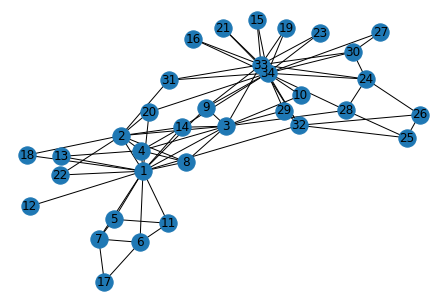

In [3]:
def read_graph():
    """
    从输入文件构建图
    """
    # 创建有向无权图 
    nx_graph = nx.read_edgelist(INPUT_PATH, nodetype=int, create_using=nx.DiGraph())
    # 设置边权重
    for edge in nx_graph.edges():
        nx_graph[edge[0]][edge[1]]["weight"] = 1
    # 将有向图转换为无向图
    nx_graph = nx_graph.to_undirected()
    return nx_graph

nx_graph = read_graph()
nx.draw(nx_graph, with_labels=True)
plt.show()

## 计算节点与边的 Alias Table

In [8]:
def alias_setup(normalized_probs):
    """
    Alias方法初始化
    """
    n = len(normalized_probs)
    probs = np.zeros(n)
    alias = np.zeros(n, dtype=np.int)
    
    # 将概率分成大于1与小于1的两组
    smaller, larger = [], []
    for i, p in enumerate(normalized_probs):
        probs[i] = p * n
        if probs[i] < 1.0:
            smaller.append(i)
        else:
            larger.append(i)
            
    # 使用贪心算法将概率小于1的不断填满
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()
        
        alias[small] = large
        # 更新概率
        probs[large] = probs[large] - (1.0 - probs[small])
        if probs[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)
            
    return probs, alias


def alias_draw(probs, alias):
    """
    Alias方法采样
    """
    n = len(probs)
    index = int(np.floor(np.random.rand() * n))
    if np.random.rand() < probs[index]:
        return index
    else:
        return alias[index]


class Graph:
    
    def __init__(self, nx_graph, p, q):
        self.nx_graph = nx_graph
        self.p = p
        self.q = q
        
    def get_alias_edge(self, u, v):
        """
        获取指定边的Alias初始化列表
        """
        unnormalized_probs = []
        # 论文算法
        for k in sorted(self.nx_graph.neighbors(v)):
            if k == u:
                unnormalized_probs.append(self.nx_graph[v][k]["weight"] / self.p)
            elif self.nx_graph.has_edge(k, u):
                unnormalized_probs.append(self.nx_graph[v][k]["weight"])
            else:
                unnormalized_probs.append(self.nx_graph[v][k]["weight"] / self.q)
        
        # 归一化
        norm_const = sum(unnormalized_probs)
        normalized_probs = [p / norm_const for p in unnormalized_probs]
        
        return alias_setup(normalized_probs)
        
    def preprocess_transition_probs(self):
        """
        预处理转移概率
        """
        alias_nodes = {}
        # 节点概率和归一化
        for u in self.nx_graph.nodes():
            unnormalized_probs = [self.nx_graph[u][v]["weight"] for v in sorted(self.nx_graph.neighbors(u))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [p / norm_const for p in unnormalized_probs]
            alias_nodes[u] = alias_setup(normalized_probs)
            
            # 输出展示信息
            if u == 2:
                print("node 2 unnormalized_probs:", unnormalized_probs)
                print("node 2 norm_const:", norm_const)
                print("node 2 normalized_probs:", normalized_probs)
                print("node 2 alias_node:", alias_nodes[u])
                
        alias_edges = {}
        for e in self.nx_graph.edges():
            alias_edges[(e[0], e[1])] = self.get_alias_edge(e[0], e[1])
            alias_edges[(e[1], e[0])] = self.get_alias_edge(e[1], e[0])
        print("edge 2->3 alias_edge:", alias_edges[(2, 3)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges
        
    def generate_node2vec_walk(self, start_node, walk_length):
        """
        生成一条基于Node2Vec算法的随机游走路径
        """
        walk = [start_node]
        
        # 生成指定长度的节点序列
        while len(walk) < walk_length:
            curr_node = walk[-1]
            # 这里对节点进行排序，保证与AliasTable计算顺序对齐
            neighbor_nodes = sorted(self.nx_graph.neighbors(curr_node))
            if len(neighbor_nodes) > 0:
                # 序列当中只有一个节点
                if len(walk) == 1:
                    index = alias_draw(self.alias_nodes[curr_node][0], self.alias_nodes[curr_node][1])
                    walk.append(neighbor_nodes[index])
                # 序列当中大于一个节点
                else:
                    prev_node = walk[-2]
                    index = alias_draw(self.alias_edges[(prev_node, curr_node)][0], self.alias_edges[(prev_node, curr_node)][1])
                    walk.append(neighbor_nodes[index])
            else:
                break
        
        return walk
    
    def generate_node2vec_walks(self, num_walks, walk_length):
        """
        生成多组基于Node2Vec算法的随机游走路径
        """
        walks, nodes = [], list(self.nx_graph.nodes())
        
        print("Walk Iteration:")
        for i in range(num_walks):
            print(i + 1, "/", num_walks)
            
            # 打乱节点顺序
            random.shuffle(nodes)
            for u in nodes:
                walks.append(self.generate_node2vec_walk(u, walk_length))

        return walks

In [9]:
graph = Graph(nx_graph, p=1, q=1)
graph.preprocess_transition_probs()

node 2 unnormalized_probs: [1, 1, 1, 1, 1, 1, 1, 1, 1]
node 2 norm_const: 9
node 2 normalized_probs: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
node 2 alias_node: (array([1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]))
edge 2->3 alias_edge: (array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


## 生成节点序列

In [13]:
walks = graph.generate_node2vec_walks(num_walks=10, walk_length=80)

print("Walk Length:", len(walks[0]))

Walk Iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Walk Length: 80


## 使用Word2Vec训练模型

In [16]:
def learn_word2vec_embedding(walks):
    """
    根据节点序列学习Embedding
    """
    # 将节点由int类型转换为string类型
    sentences = []
    for walk in walks:
        sentences.append([str(x) for x in walk])
        
    model = Word2Vec(sentences, size=128, window=10, min_count=0, sg=1, workers=4, iter=1)
    model.wv.save_word2vec_format(OUTPUT_PATH)
    return model
    
model = learn_word2vec_embedding(walks)
print("Learning Finish.")

Learning Finish.


## 结果展示

In [18]:
print("Node 17 Embedding:")
print(model.wv["17"])

Node 17 Embedding:
[ 0.11610381 -0.09863545 -0.10598327  0.2590956  -0.05881816  0.13882357
  0.01087395 -0.16025585 -0.085508   -0.03141596 -0.15733844  0.1467154
  0.10760591 -0.19341302 -0.08693919  0.2202293   0.044776    0.20408337
  0.06290071  0.0765036  -0.05671148 -0.12998486 -0.01393018  0.20872758
  0.05539635  0.00900809  0.21510918 -0.12499711  0.16901357 -0.04921738
  0.22541103 -0.26438805  0.12965742 -0.08639374  0.13922651 -0.21590902
  0.1274849   0.11383393 -0.09182981 -0.29865608  0.03012002  0.01298947
 -0.25775808 -0.14327201 -0.03490397  0.05123614  0.09999209 -0.02998499
  0.22785197 -0.00555171 -0.21018597 -0.11993086  0.03346585 -0.29764158
  0.06468447 -0.18042901 -0.03317702 -0.07605142 -0.16073482  0.08607846
 -0.08177924 -0.26353684  0.07656667  0.11809298 -0.10821946 -0.11948624
  0.07811957 -0.03748534  0.08687314  0.08061471 -0.03247282 -0.28774664
  0.06127965  0.24729133  0.1020148   0.19702682 -0.04889841  0.01793455
 -0.08411136  0.05449267 -0.04691

In [21]:
print("Node 17 and 6 Similarity:", model.wv.similarity("17", "6"))
print("Node 17 and 25 Similarity:", model.wv.similarity("17", "25"))

Node 17 and 6 Similarity: 0.9986441
Node 17 and 25 Similarity: 0.76830983
